# Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import plot_importance, XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [4]:
ds = pd.read_csv('/content/dataset.csv')
ds.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [5]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


# Performing some basic Feature Engineering

Created a feature `km_per_driving_day` representing the mean number of kilometers driven on each day of driving.

In [6]:
ds['km_per_driving_day'] = ds['driven_km_drives'] / ds['driving_days']

ds['km_per_driving_day'].describe()

,km_per_driving_day
count,1.499900e+04
mean,inf
std,NaN
min,3.022063e+00
25%,1.672804e+02
50%,3.231459e+02
75%,7.579257e+02
max,inf


Infinite values in the `km_per_driving_day` column are replaced with 0 to handle data inconsistencies resulting from 'division by zero' errors:

In [7]:
ds.loc[ds['km_per_driving_day']==np.inf, 'km_per_driving_day']=0

Created a feature `percent_sessions_in_last_month` by dividing `sessions` by `total_sessions` to normalize recent user activity

In [8]:
ds['percent_sessions_in_last_month'] = ds['sessions'] / ds['total_sessions']

Created a feature `professional_driver` that represents the percentage of each user's total sessions that were logged, in the last month

In [9]:
ds['professional_driver'] = np.where((ds['drives'] >= 60) & (ds['driving_days'] >= 15), 1, 0)

Converted the feature `professional_driver` to a binary feature. It shows 1 for a user who had 60 or more drives and drove on 15+ days and 0 otherwise

In [10]:
ds['total_sessions_per_day'] = ds['total_sessions'] / ds['n_days_after_onboarding']

Created a feature `km_per_hour` that represents the average driving speed

In [11]:
ds['km_per_hour'] = ds['driven_km_drives'] / (ds['duration_minutes_drives'] / 60)

Created a feature `km_per_drive` that represents the mean number of kilometers driven

In [12]:
ds['km_per_drive'] = ds['driven_km_drives'] / ds['drives']

ds['km_per_drive'].describe()

,km_per_drive
count,1.499900e+04
mean,inf
std,NaN
min,1.008775e+00
25%,3.323065e+01
50%,7.488006e+01
75%,1.854667e+02
max,inf


In [13]:
ds.loc[ds['km_per_drive'] == np.inf, 'km_per_drive']=0

Created a feature `percent_of_drives_to_favorite` that represents the proportion of user's total navigation sessions that end at one of their top two saved favorite locations

In [14]:
ds['percent_of_drives_to_favorite'] = (ds['total_navigations_fav1'] + ds['total_navigations_fav2']) / ds['total_sessions']

Dropped the rows with null values

In [15]:
df = ds.dropna()

In [16]:
df.isnull().sum().sum()

np.int64(0)

Created a new numerical feature `device2` by mapping the categorical device column to binary integer values, where Android is 0 and iPhone is 1.

In [17]:
df['device2'] = df['device'].map({'Android': int(0), 'iPhone': int(1)})
df[['device','device2']].head()

,device,device2
0,Android,0
1,iPhone,1
2,Android,0
3,iPhone,1
4,Android,0


Created a new numerical feature `label2` by mapping the categorical device column to binary integer values, where retained is 0 and churned is 1.

In [18]:
df['label2'] = df['label'].map({'retained': int(0), 'churned': int(1)})
df = df.drop(columns = ['ID'], axis = 1)

In [19]:
df[['label','label2']].sample(5)

,label,label2
4398,retained,0
11026,retained,0
1988,retained,0
5733,retained,0
3317,retained,0


In [20]:
df['label'].value_counts(normalize = True)

,proportion
label,
retained,0.822645
churned,0.177355


Approximately 18% of users in this dataset churned, as observed in the initial analysis. While the dataset is unbalanced, the distribution is not severely skewed; therefore, it can be modeled effectively without mandatory class rebalancing techniques.

Split the data into a 60% training, 20% testing, and 20% validation set

In [21]:
X = df.drop(columns = ['device', 'label', 'label2'], axis = 1)
y = df['label2']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify =y, test_size = 0.20, random_state = 42)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.25, stratify = y_train, random_state = 42)

In [22]:
for x in [X_train, y_train, X_val, X_test]:
    print(len(x))

11439
11439
2860
2860


Set up a `GridSearchCV` object to tune the `RandomForestClassifier` hyperparameters. The search will evaluate various combinations of `n_estimators`, `max_depth`, and other parameters, using 'recall' as the primary metric for refitting


---

## Why We Prioritize Recall

In churn prediction, our main objective is to identify users who are likely to stop using the app so we can intervene early.

We focus on **recall** because it measures the proportion of actual churners that we correctly identify. In this context:

- False negatives (missing a churner) are costly, the user leaves undetected, leading to lost engagement and revenue.
- False positives (flagging a retained user as at risk) are low-cost, we might send an unnecessary notification or offer, which has minimal downside and could even boost activity.

Given this trade-off, it’s better to cast a wider net and follow up with more users than to miss those truly at risk.

While precision and accuracy are informative, they can be misleading, especially when dealing with imbalanced classes. Since only about 18% of users in the dataset churned, a model could achieve high accuracy simply by predicting "retained" for everyone.

Therefore, **recall** provides a more meaningful measure of performance for the company's retention strategy.

# Modelling

In [23]:
ran_for = RandomForestClassifier(random_state = 0, n_jobs = -1)

scoring = ['accuracy', 'precision', 'recall', 'f1']

cross_val_params = {
    'n_estimators': [100, 150],
    'max_depth': [5, 7, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

ran_for_cv = GridSearchCV(ran_for, cross_val_params, scoring = scoring, cv = 4, refit = 'recall')

Execute the configured `GridSearchCV` operation, fitting the model to the training data. The `%%time` magic command will measure the duration of this fitting process



In [24]:
%%time
ran_for_cv.fit(X_train, y_train)

CPU times: user 7min 29s, sys: 2.65 s, total: 7min 31s
Wall time: 4min 25s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 150]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [25]:
ran_for_cv.best_score_

np.float64(0.1187702868502384)

In [26]:
ran_for_cv.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 150}

In [27]:
def make_results(model_name:str, model_object, metric:str):
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    cv_results = pd.DataFrame(model_object.cv_results_)

    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [28]:
results = make_results('RF cv', ran_for_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.494327,0.11877,0.1912,0.821925


The initial model performance metrics (apart from accuracy) indicate the need for a more robust approach. We will now implement an XGBoost Classifier to better handle the dataset's characteristics and improve overall scores

Set up `GridSearchCV` for the `XGBClassifier` using a defined parameter grid. The search will tune key hyperparameters such as `n_estimators` and `max_depth`, using 'recall' as the primary metric for selecting the best model

In [29]:
xgb = XGBClassifier(objective = 'binary:logistic' ,random_state = 67, n_jobs = -1)

cv_params_xgb = {
    'n_estimators': [50, 100, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [3, 5]
}

scoring = ['accuracy', 'precision', 'recall', 'f1']

xgb_cv = GridSearchCV(xgb, cv_params_xgb, scoring=scoring, cv=4, refit='recall', n_jobs=-1)

In [30]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 2.09 s, sys: 88.2 ms, total: 2.18 s
Wall time: 34.1 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'min_child_weight': [3, 5],
                         'n_estimators': [50, 100, 300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [31]:
xgb_cv.best_score_

np.float64(0.15622913075214712)

In [32]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 300}

In [33]:
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.494327,0.118770,0.191200,0.821925
0,XGB cv,0.439997,0.156229,0.230536,0.815018


The XGBoost model shows a significant improvement in recall (approximately a 31% increase over the Random Forest model), while maintaining similar accuracy and precision scores.


# Model Selection

In [34]:
rf_val_preds = ran_for_cv.best_estimator_.predict(X_val)

In [35]:
def get_test_scores(model_name:str, preds, y_test_data):
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [36]:
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.494327,0.118770,0.191200,0.821925
0,XGB cv,0.439997,0.156229,0.230536,0.815018
0,RF val,1.000000,0.966469,0.982949,0.994056


The validation results for the Random Forest model show a significant difference from the cross-validation scores, indicating potential **overfitting** on the validation data.

Comparing the cross-validation results, the XGBoost model still offers a superior recall score (a 31% improvement over the RF CV score) while maintaining competitive accuracy and precision

In [37]:
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.494327,0.118770,0.191200,0.821925
0,XGB cv,0.439997,0.156229,0.230536,0.815018
0,RF val,1.000000,0.966469,0.982949,0.994056
0,XGB val,0.977011,0.502959,0.664062,0.909790



The validation results highlight a significant difference from the cross-validation scores for both models, indicating a degree of overfitting to the validation data.

Comparing the validation metrics:
*   The Random Forest validation scores are extremely high (precision 1.0, accuracy 99.4%), suggesting the model generalized poorly outside of its immediate training context or that the validation split was too easy.
*   The XGBoost validation scores, while lower than RF, offer a more realistic performance assessment with a recall of 0.50.

Based purely on the cross-validation scores (which are a more robust estimate of true performance), the XGBoost model offers better generalized recall compared to the Random Forest model.

In [38]:
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.494327,0.118770,0.191200,0.821925
0,XGB cv,0.439997,0.156229,0.230536,0.815018
0,RF val,1.000000,0.966469,0.982949,0.994056
0,XGB val,0.977011,0.502959,0.664062,0.909790
0,XGB test,0.429379,0.149901,0.222222,0.813986


The results compare cross-validation, validation, and test set metrics for both the Random Forest (RF) and XGBoost models.

Key observations:

*   Overfitting: High validation scores compared to cross-validation and test scores suggest overfitting occurred in both models.
*   XGBoost Performance: The XGBoost test metrics (precision: 0.429, recall: 0.150) offer the most realistic assessment of generalization.
*   Best CV Metrics: Based on robust cross-validation, the XGBoost model provided better recall than the Random Forest model (0.156 vs 0.118).

# Displaying the Confusion Matrix

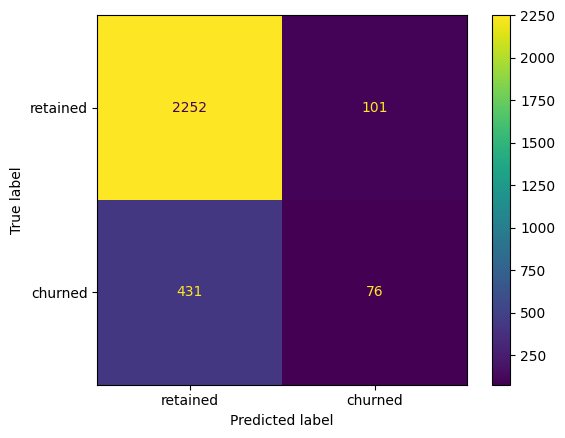

In [39]:
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

## Confusion Matrix Interpretation

The confusion matrix above shows how our final XGBoost model performed on the **test set** (2,860 users):

- **True Negatives (TN)**: 2,252 users correctly predicted as `retained`  
- **False Positives (FP)**: 101 users incorrectly flagged as `churned` (when they were retained)  
- **False Negatives (FN)**: 431 users incorrectly predicted as `retained` (when they actually churned)  
- **True Positives (TP)**: 76 users correctly identified as `churned`

### Key Insights:
- **Recall (Sensitivity)**: Our model correctly identified **76 out of 507 actual churners** (76 / (76 + 431) = 15.0%), this aligns with our test recall score.
- **Precision**: Of the 177 users flagged as churners (76 TP + 101 FP), only 43% were correct, this reflects the challenge of identifying rare events in an imbalanced dataset.
- **Business Impact**: While we miss many churners (high FN), the low cost of false alarms (FP) makes this acceptable for proactive retention campaigns.

This visualization reinforces why **recall is prioritized**: catching even a small percentage of true churners allows the company to intervene early, potentially saving revenue and user engagement.

# Feature Importance

Used the `plot_importance` function to inspect the most important features in our final model

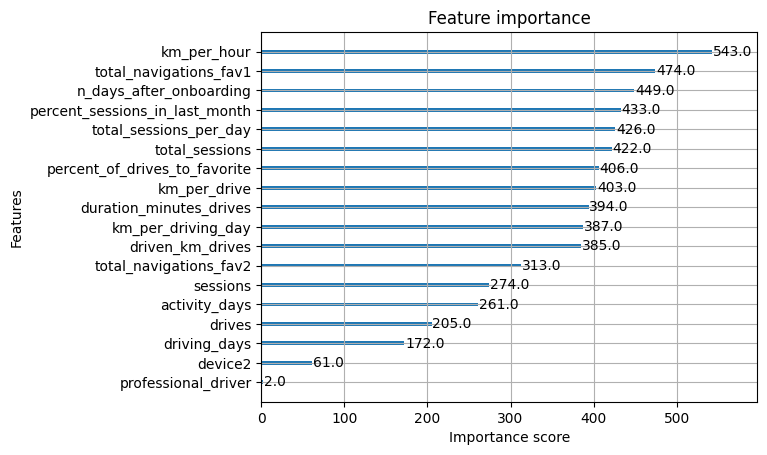

In [40]:
plot_importance(xgb_cv.best_estimator_);

## Feature Importance Analysis

The bar chart above shows the relative importance of each feature in our final XGBoost model, as determined by the algorithm's internal gain metric. Higher scores indicate features that contributed more to reducing prediction error during training.

### Key Insights:
- **Top 3 Most Important Features:**
  1. `km_per_hour` – Average driving speed is the strongest predictor. Users who drive faster may be more engaged or have different usage patterns.
  2. `total_navigations_fav1` – Number of trips to a user’s #1 saved favorite location. High engagement with personal destinations correlates strongly with retention.
  3. `n_days_after_onboarding` – Time since using the app. Newer users are more likely to churn, while long-term users are more stable.

- **Lowest Impact Features:**
  - `professional_driver` (score = 2.0) – Surprisingly, being a “professional” driver (≥60 drives & ≥15 driving days) had almost no predictive power. This suggests that raw activity volume alone isn’t enough to predict churn, context (like *where* and *how* they drive) matters more.

### Business Implications:
- Focus retention efforts on users with low `km_per_hour` or infrequent use of favorite locations.
- Consider targeting newer users (<30 days) with onboarding incentives or personalized tips.
- The low importance of `device2` (Android/iPhone) suggests platform doesn’t significantly affect churn good news for cross-platform strategy.

This analysis helps prioritize which user behaviors to monitor and intervene on, turning model outputs into actionable business intelligence.

# Model Export

To make our trained model reusable and deployable, we save it using Python's `pickle` module. This allows us to load the model later for predictions on new data without retraining.

In [41]:
best_model = xgb_cv.best_estimator_

model_filename = 'xgboost_churn_model.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best model (XGBoost) saved as '{model_filename}'")

Best model (XGBoost) saved as 'xgboost_churn_model.pkl'


In [42]:
from google.colab import files
files.download(model_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>